In [1]:
# unset PYTHONPATH first
from ko_text import *
from ko_crawler import *

import ast

In [2]:
nlp = NLP()

In [3]:
train_df = pd.read_csv('Data/train_df.csv',
                       usecols = ['Token','Section'],
                       dtype = {'Section' : 'category'},
                       converters = {'Token' : ast.literal_eval},
                     )

test_df = pd.read_csv('Data/test_df.csv',
                       usecols = ['Token','Section'],
                       dtype = {'Section' : 'category'},
                       converters = {'Token' : ast.literal_eval},
                     )

In [4]:
train_df.shape

(90000, 2)

# **TF-IDF**

In [6]:
tfidf_df = nlp.doc_to_tfidf_df(train_df['Token'])

## **1. Keyword 추출**

In [7]:
first_keyword_ls, second_keyword_ls = nlp.keyword_ls_from_tfidf_df()

In [8]:
train_df['1st_keyword'] = first_keyword_ls

In [9]:
train_df.head(5)

,Token,Section,1st_keyword
0,"[NH, 농협, 금융, 지주, 김광수, 회장, 22일, 서대문, 본사, 에서, 농협...",경제,회장
1,"[바이오, 직스, 올해, 개별, 기준, 3분, 영업, 이익, 105억원, 으로, 작...",경제,바이오
2,"[코스피, 붕괴하면서, 달러, 환율, 으로, 뛰었다, 23일, 서울, 외환시장, 에...",경제,거래
3,"[정의당, 국회, 롯데, 갑질, 피해자, 간담, 개최, 김상조, 정거, 위원장, 2...",경제,롯데
4,"[코스피, 23일, 무역, 전쟁, 내외, 악재, 힘없이, 2110, 내줬다, 코스피...",경제,무역


## **2. Classification**

<br>


<br>


<br>


<br>


<br>


# **Doc2Vec**

## **1. Doc2Vec 모델 불러오기**

In [17]:
# 가장 성능이 좋았던 모델들 호출
'''
Doc2Vec_model/Doc2Vec_dm=True&cc=9999&vs=100&win=5&neg=5&min=10&sample=1e-05&epochs=10

'''
nlp.load_Doc2Vec_model('Doc2Vec_model/Doc2Vec_dm=True&cc=9999&vs=100&win=5&neg=5&min=10&sample=1e-05&epochs=10')

## **Doc2Vec train** 

In [6]:
'''nlp.train_Doc2Vec_model(train_df['Token'],
                        train_df['Section'],
                        n_epochs = 10)'''

## **Doc2Vec 학습결과 확인**

#### **9999개의 문서로 build하고 9999개 문서로 train**

In [18]:
nlp.Doc2Vec_model.train_count

1

In [96]:
nlp.Doc2Vec_model.most_similar('경제')

[('기적', 0.9728723764419556),
 ('경질', 0.9646653532981873),
 ('내놓았다', 0.9638350009918213),
 ('이뤄질', 0.9593904614448547),
 ('교역', 0.9562650322914124),
 ('가능성', 0.949462890625),
 ('우려', 0.9482637643814087),
 ('감당', 0.9481964111328125),
 ('양극화', 0.9472314119338989),
 ('유류', 0.9463865756988525)]

<br>


<br>


## **Data setting**

In [94]:
##################################
# 한 label마다 학습할 단어의 수
train_size_for_each_label = 10000
test_size_for_each_label = 1000
###################################


# 분류기의 성능을 테스트하기 위해 선정된 section list
testing_section_ls = np.unique(train_df['Section'])
#testing_section_ls = ['사회','IT과학','경제']

# 전체를 모두 학습하면 시간이 오래걸림.
# 분류기별 성능 비교를 위해, 부분만 학습하기 위한 전처리 작업
train_df2 = train_df[train_df['Section'].isin(testing_section_ls)]
train_df2.index = np.arange(0,len(train_df2))

test_df2 = test_df[test_df['Section'].isin(testing_section_ls)]
test_df2.index = np.arange(0,len(test_df2))

n_class = len(test_df2['Section'].unique())


# Doc2Vec으로 vector를 추정하기 위한 split 과정
train_batch_size = n_class * train_size_for_each_label
test_batch_size = n_class * test_size_for_each_label

train_token_ls_split, train_tag_ls_split = nlp.split_X_y_equally(train_df2['Token'], train_df2['Section'], train_batch_size)
test_token_ls_split, test_tag_ls_split =  nlp.split_X_y_equally(test_df2['Token'],test_df2['Section'], test_batch_size)

n_batch = len(train_token_ls_split)


#X_train = nlp.doc_to_tfidf_df(train_token_ls_split[0])
X_train = nlp.infer_vectors_with_Doc2Vec(train_token_ls_split[0])
y_train = train_tag_ls_split[0]

#X_test = nlp.doc_to_tfidf_df(test_token_ls_split[0])
X_test = nlp.infer_vectors_with_Doc2Vec(test_token_ls_split[0])
y_test = test_tag_ls_split[0]

from collections import Counter
Counter(y_train)

Counter({'IT과학': 10000,
         '경제': 10000,
         '국제': 10000,
         '기업': 10000,
         '문화': 10000,
         '부동산': 10000,
         '사회': 10000,
         '정치': 10000,
         '증권': 10000})

<br>


# **Logistic Regression**

In [95]:
clf = LogisticRegression(solver = 'newton-cg',
                         multi_class = 'multinomial')


clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy : ', accuracy_score(y_pred, y_test))

Accuracy :  0.6247777777777778


<br>



# **Decision Tree**

Decision Tree 모델은 feature들이 각각 의미있는 변수들이면서, 독립적으로 사용될 수 있을 때 유용한 방법이다.


각 변수별로 적절한 기준선을 찾아 공간을 나누기 때문.

따라서 Doc2Vec과 같이 좌표평면상에서 벡터의 위치가 아무런 의미가 없는 경우, 학습 효과가 현저하게 떨어진다.

In [68]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [69]:
clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy : ', accuracy_score(y_pred, y_test))

Accuracy :  0.6953333333333334


<br>



# **RandomForestClassifier**

In [70]:
from sklearn.ensemble import RandomForestClassifier

In [71]:
clf = RandomForestClassifier(n_estimators=100,  n_jobs = -1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
    
print('Accuracy : ', accuracy_score(y_pred, y_test))

Accuracy :  0.7933333333333333


<br>



# **Neural Net**

In [72]:
from sklearn.metrics import confusion_matrix
import tensorflow as tf

## **Data Preprocessing**

In [73]:
X_train_nn = np.array(X_train).astype('float32')
y_train_nn = pd.get_dummies(y_train).values.astype('float32')


X_test_nn = np.array(X_test).astype('float32')
y_test_nn = pd.get_dummies(y_test).values.astype('float32')

In [74]:
print(X_train_nn.shape, y_train_nn.shape, X_test_nn.shape, y_test_nn.shape)

(300, 100) (300, 3) (3000, 100) (3000, 3)


## **Build Layers**

In [88]:
# reset graphs
tf.reset_default_graph() 

# mini-batches
batch_size = X_train_nn.shape[0] // 5
dataset = tf.data.Dataset.from_tensor_slices((X_train_nn, y_train_nn))
dataset = dataset.batch(batch_size)

# building placeholder
X = tf.placeholder(tf.float32, shape = [None, nlp.Doc2Vec_model.vector_size])
Y = tf.placeholder(tf.float32, shape = [None, n_class])
keep_prob = tf.placeholder(tf.float32)

# building layers
n_neuron = 100

W1 = tf.get_variable('W1', shape = ([nlp.Doc2Vec_model.vector_size, n_neuron]), initializer = tf.contrib.layers.xavier_initializer())
W2 = tf.get_variable('W2', shape = ([n_neuron, n_neuron]), initializer = tf.contrib.layers.xavier_initializer())
W3 = tf.get_variable('W3', shape = ([n_neuron, n_neuron]), initializer = tf.contrib.layers.xavier_initializer())
W4 = tf.get_variable('W4', shape = ([n_neuron, n_neuron]), initializer = tf.contrib.layers.xavier_initializer())
W5 = tf.get_variable('W5', shape = ([n_neuron, n_class]), initializer = tf.contrib.layers.xavier_initializer())

b1 = tf.Variable(tf.random_normal([n_neuron]))
b2 = tf.Variable(tf.random_normal([n_neuron]))
b3 = tf.Variable(tf.random_normal([n_neuron]))
b4 = tf.Variable(tf.random_normal([n_neuron]))
b5 = tf.Variable(tf.random_normal([n_class]))

L1 = tf.nn.relu(tf.matmul(X,W1) + b1)
L1 = tf.nn.dropout(L1, keep_prob = keep_prob)

L2 = tf.nn.relu(tf.matmul(L1,W2) + b2)
L2 = tf.nn.dropout(L2, keep_prob = keep_prob)

L3 = tf.nn.relu(tf.matmul(L2,W3) + b3)
L3 = tf.nn.dropout(L3, keep_prob = keep_prob)

L4 = tf.nn.relu(tf.matmul(L3,W4) + b4)
L4 = tf.nn.dropout(L4, keep_prob = keep_prob)

logit = tf.matmul(L4,W5) + b5
hypothesis = tf.nn.softmax(tf.matmul(L4,W5) + b5)


# cost : cross - entropy cost 
lamb = 0.0001
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logit, labels = Y)) + lamb * tf.reduce_sum(tf.square(W5))

# optimize
learning_rate = 0.0001
train = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

# prediction
prediction = tf.argmax(hypothesis,1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y,1), prediction), dtype= tf.float32))



# restore results
train_cost_list = []
train_acc_list = []

test_cost_list = []
test_acc_list = []


# **Run**

### **mini-batch**

In [89]:
# train_dict = {X: X_train, Y: y_train}
test_dict = {X: X_test_nn, Y: y_test_nn, keep_prob : 1}

training_epochs = 500

iterator = dataset.make_initializable_iterator()
f, l = iterator.get_next()

# launch graph
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())    
    
    
    for epoch in range(training_epochs):
        # iterator initialize
        sess.run(iterator.initializer)
        avg_cost = 0

        while True:
            # mini-batch
            try:
                batch_x,  batch_y = sess.run([f, l])
                feed_dict = {X : batch_x, Y: batch_y, keep_prob : 0.7}
                
                c, _ = sess.run([cost, train], feed_dict = feed_dict)
                avg_cost += c
            
            except tf.errors.OutOfRangeError:
                    break
        
        acc, y_pred, test_cost = sess.run([accuracy, prediction, cost], feed_dict = test_dict)
        
        train_cost_list.append(avg_cost)
        test_cost_list.append(test_cost)
            
        if (epoch+1) % (100) == 0 :
            
            test_acc_list.append(acc)
            
            print('Epoch : %s'%(epoch+1), 'cost :',test_cost)
            print('Accuracy :', acc)
        #print(sess.run(tf.confusion_matrix(labels = tf.reshape(Y, [-1]), predictions = tf.reshape(y_pred, [-1])), feed_dict = test_dict))


Epoch : 100 cost : 0.7566189
Accuracy : 0.64633334
Epoch : 200 cost : 0.66327316
Accuracy : 0.72433335
Epoch : 300 cost : 0.6461452
Accuracy : 0.7553333
Epoch : 400 cost : 0.6432798
Accuracy : 0.7686667
Epoch : 500 cost : 0.6409908
Accuracy : 0.7726667
Epoch : 600 cost : 0.6374331
Accuracy : 0.779
Epoch : 700 cost : 0.6405602
Accuracy : 0.78333336
Epoch : 800 cost : 0.65201515
Accuracy : 0.785
Epoch : 900 cost : 0.66087264
Accuracy : 0.7876667
Epoch : 1000 cost : 0.6706369
Accuracy : 0.78933334


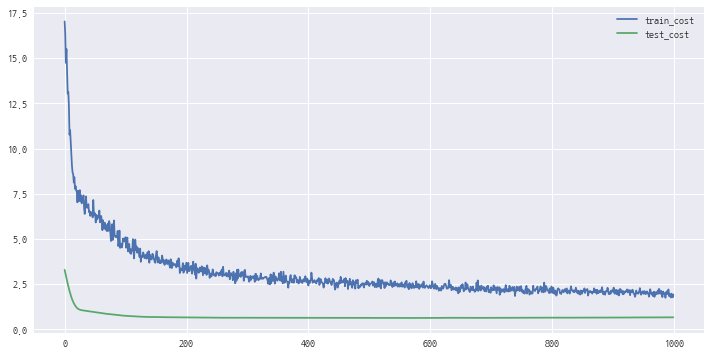

In [91]:
plt.figure(figsize = (12,6))
plt.plot(train_cost_list, label = 'train_cost')
plt.plot(test_cost_list, label = 'test_cost')
plt.legend(loc = 'best')